In [1]:
# import relevant libraries
import pandas as pd
import xml.etree.ElementTree as ET
import time

### Step 1: Parse DrugBank XML file

In [2]:
# set location of XML file
drugbank_xml_file_path = 'input/drugbank_full_database_5-1-8.xml'

# set namespace value found in XML file
name_space = '{http://www.drugbank.ca}'

In [3]:
# set start time
start = time.time()

# parse XML file and set root
tree = ET.parse(drugbank_xml_file_path)
root = tree.getroot()

# set end time
end = time.time()

print('Number of records in DrugBank XML file: %i' % len(root))
print('Time taken to load DrugBank XML file: %i seconds' % (end - start))

Number of records in DrugBank XML file: 14315
Time taken to load DrugBank XML file: 50 seconds


In [4]:
# iterate through each record to extract relevant drug information

all_drugs_list = list()

def set_drug_type(drug):
    drug_type = drug.get('type')
    if drug_type == 'biotech':
        categories = [category.text for category in drug.findall("{name_space}categories/{name_space}category/{name_space}category".format(name_space = name_space))]
        drug_type = 'antibody' if 'Antibodies' in categories else 'other'
    return drug_type

for i, drug in enumerate(root):
    drug_entry = {}
    assert drug.tag == name_space + 'drug'
    drug_entry['drugbank_id'] = drug.findtext(name_space + "drugbank-id[@primary='true']")
    drug_entry['name'] = drug.findtext(name_space + "name")
    drug_entry['type'] = set_drug_type(drug)
    drug_entry['groups'] = [group.text for group in drug.findall("{name_space}groups/{name_space}group".format(name_space = name_space))]
    all_drugs_list.append(drug_entry)
    
print('Number of records found in all_drugs_list: %i' % len(all_drugs_list))

Number of records found in all_drugs_list: 14315


In [5]:
# create DataFrame with list of drugs and relevant drug information

all_drugs_df = pd.DataFrame(all_drugs_list)
all_drugs_df.head(5)

,drugbank_id,groups,name,type
0,DB00001,[approved],Lepirudin,other
1,DB00002,[approved],Cetuximab,antibody
2,DB00003,[approved],Dornase alfa,other
3,DB00004,"[approved, investigational]",Denileukin diftitox,other
4,DB00005,"[approved, investigational]",Etanercept,antibody


In [6]:
# save DataFrame as CSV
all_drugs_df.to_csv('output/drugbank_database_slim.csv', index=False)

### Step 2: Parse DrugBank pharmacologically active targets CSV file 

In [7]:
# set location of DrugBank target file
drugbank_target_file_path = 'input/drugbank_pharmacologically_active_targets_5-1-8.csv'

In [8]:
# import file into DataFrame
drugbank_targets_df = pd.read_csv(drugbank_target_file_path, sep=',')
print('Number of records found in DrugBank pharmacologically active CSV file: %i' % len(drugbank_targets_df))

Number of records found in DrugBank pharmacologically active CSV file: 1317


In [9]:
# explore DataFrame with DrugBank target information
drugbank_targets_df.head(5)

,ID,Name,Gene Name,GenBank Protein ID,GenBank Gene ID,UniProt ID,Uniprot Title,PDB ID,GeneCard ID,GenAtlas ID,HGNC ID,Species,Drug IDs
0,1,Peptidoglycan synthase FtsI,ftsI,1574687.0,L42023,P45059,FTSI_HAEIN,NaN,NaN,NaN,NaN,Haemophilus influenzae (strain ATCC 51907 / DS...,DB00303
1,4,Coagulation factor XIII A chain,F13A1,182309.0,M22001,P00488,F13A_HUMAN,1EVU; 1EX0; 1F13; 1FIE; 1GGT; 1GGU; 1GGY; 1QRK...,NaN,F13A1,HGNC:3531,Humans,DB11300; DB11311; DB11571; DB13151
2,5,"Nitric oxide synthase, inducible",NOS2,292242.0,L09210,P35228,NOS2_HUMAN,1NSI; 2LL6; 2NSI; 3E7G; 3EJ8; 3HR4; 4CX7; 4NOS,NaN,NOS2A,HGNC:7873,Humans,DB08814
3,8,"NAD(P) transhydrogenase, mitochondrial",NNT,1110520.0,U40490,Q13423,NNTM_HUMAN,1DJL; 1PT9; 1U31,NaN,NNT,HGNC:7863,Humans,DB09092
4,11,"Isocitrate dehydrogenase [NAD] subunit alpha, ...",IDH3A,706839.0,U07681,P50213,IDH3A_HUMAN,NaN,NaN,IDH3A,HGNC:5384,Humans,DB09092


In [10]:
# print list of species found in DataFrame
drugbank_targets_df['Species'].value_counts()

Humans                                                                                           1095
Escherichia coli (strain K12)                                                                      40
Escherichia coli                                                                                    9
Streptococcus pneumoniae serotype 4 (strain ATCC BAA-334 / TIGR4)                                   8
Mycobacterium tuberculosis                                                                          7
Klebsiella pneumoniae                                                                               7
Gram positive and gram negative bacteria                                                            7
Clostridium botulinum                                                                               7
Staphylococcus aureus                                                                               6
Yeast                                                                             

In [11]:
# filter DataFrame for only human data
drugbank_human_targets_df = drugbank_targets_df[drugbank_targets_df['Species'] == 'Humans'].copy()
print('Number of records where Species == "Human": %i' % len(drugbank_human_targets_df))

Number of records where Species == "Human": 1095


### Step 3: Create DrugBank clinical targets CSV export

In [12]:
all_rows = list()

clinic_drug_groups = [
    'approved',
    'investigational',
    'withdrawn'
]

def filter_drug_list(list_of_drugs, modality):
    my_list = list()
    for drug in list_of_drugs:
        drug_groups = drug['groups']
        if any(group in drug_groups for group in clinic_drug_groups):
            if drug['type'] == modality:
                my_list.append(drug)
    return my_list

def handle_no_drug_data(drug_id):
    drug_obj = {
        'drugbank_id': drug_id,
        'name': 'unknown',
        'type': 'unknown',
        'groups': 'unknown',
    }
    return drug_obj
    
for index, row in drugbank_human_targets_df.iterrows():
    entry = {}
    entry['db_symbol'] = row['Gene Name']
    entry['accession'] = row['UniProt ID']
    drug_ids = row['Drug IDs'].split('; ')
    all_drugs = [(next((drug for drug in all_drugs_list if drug['drugbank_id'] == x), handle_no_drug_data(x))) for x in drug_ids]
    entry['db_all_drugs_in_clinic'] = all_drugs
    entry['db_small_molecule_drugs_in_clinic'] = filter_drug_list(all_drugs, 'small molecule') 
    entry['db_antibody_drugs_in_clinic'] = filter_drug_list(all_drugs, 'antibody')
    entry['db_other_drugs_in_clinic'] = filter_drug_list(all_drugs, 'other')
    entry['db_is_small_molecule_in_clinic'] = True if len(entry['db_small_molecule_drugs_in_clinic']) > 0 else False
    entry['db_is_antibody_in_clinic'] = True if len(entry['db_antibody_drugs_in_clinic']) > 0 else False
    entry['db_is_other_in_clinic'] = True if len(entry['db_other_drugs_in_clinic']) > 0 else False
    all_rows.append(entry)

In [13]:
drugbank_clinical_targets_df = pd.DataFrame(all_rows)

In [14]:
reordered_columns = [
    'accession',
    'db_symbol',
    'db_is_small_molecule_in_clinic',
    'db_is_antibody_in_clinic',
    'db_is_other_in_clinic',
    'db_small_molecule_drugs_in_clinic',
    'db_antibody_drugs_in_clinic',
    'db_other_drugs_in_clinic',
    'db_all_drugs_in_clinic',
]

In [15]:
drugbank_clinical_targets_df = drugbank_clinical_targets_df[reordered_columns]
drugbank_clinical_targets_df.to_csv('output/drugbank_clinical_targets.csv', index=False)

### Step 4: Import and parse Open Targets tractability file

In [16]:
# set location of Open Targets tractability file
tractability_file_path = 'input/open_targets_tractability_pipeline_20-11.tsv'

In [17]:
# import tractability file into DataFrame
tractability_df = pd.read_csv(tractability_file_path, sep='\t', low_memory=False)

In [18]:
tractability_df.head(5)

,ensembl_gene_id,symbol,accession,Bucket_1_sm,Bucket_2_sm,Bucket_3_sm,Bucket_4_sm,Bucket_5_sm,Bucket_6_sm,Bucket_7_sm,...,Bucket_3_othercl,Bucket_sum_othercl,Top_bucket_othercl,drug_chembl_ids_othercl,drug_names_othercl,clinical_phases_othercl,Clinical_Precedence_othercl,Category_othercl,drug_names_dict_othercl,clinical_phases_dict_othercl
0,ENSG00000146648,EGFR,P00533,1,0,0,1,1,1,0,...,0,0,10,[''],[''],NaN,0.0,Unknown,{'': ''},{'': ''}
1,ENSG00000128052,KDR,P35968,1,0,0,1,1,1,0,...,0,1,2,['CHEMBL2108557'],['TELBERMIN'],2,0.7,Clinical_Precedence_othercl,{'CHEMBL2108557': 'TELBERMIN'},{'CHEMBL2108557': '2'}
2,ENSG00000141736,ERBB2,P04626,1,0,0,1,1,1,0,...,0,0,10,[''],[''],NaN,0.0,Unknown,{'': ''},{'': ''}
3,ENSG00000005844,ITGAL,P20701,1,0,0,1,1,1,0,...,0,0,10,[''],[''],NaN,0.0,Unknown,{'': ''},{'': ''}
4,ENSG00000197635,DPP4,P27487,1,0,0,1,1,1,0,...,0,0,10,[''],[''],NaN,0.0,Unknown,{'': ''},{'': ''}


In [20]:
# print list of DataFrame columns
tractability_df.columns

Index(['ensembl_gene_id', 'symbol', 'accession', 'Bucket_1_sm', 'Bucket_2_sm',
       'Bucket_3_sm', 'Bucket_4_sm', 'Bucket_5_sm', 'Bucket_6_sm',
       'Bucket_7_sm', 'Bucket_8_sm', 'Bucket_sum_sm', 'Top_bucket_sm',
       'drug_chembl_ids_sm', 'drug_names_sm', 'clinical_phases_sm',
       'PDB_Known_Ligand', 'PDB_other', 'High_Quality_ChEMBL_compounds',
       'DrugEBIlity_score', 'Small_Molecule_Druggable_Genome_Member',
       'Category_sm', 'Clinical_Precedence_sm', 'Discovery_Precedence_sm',
       'Predicted_Tractable_sm', 'drug_names_dict_sm',
       'clinical_phases_dict_sm', 'Bucket_1_ab', 'Bucket_2_ab', 'Bucket_3_ab',
       'Bucket_4_ab', 'Bucket_5_ab', 'Bucket_6_ab', 'Bucket_7_ab',
       'Bucket_8_ab', 'Bucket_9_ab', 'Bucket_sum_ab', 'Top_bucket_ab',
       'drug_chembl_ids_ab', 'drug_names_ab', 'clinical_phases_ab',
       'Uniprot_high_conf_loc', 'GO_high_conf_loc', 'Uniprot_med_conf_loc',
       'GO_med_conf_loc', 'Transmembrane', 'Signal_peptide',
       'HPA_main_loc

In [23]:
# create copy of original tractability DataFrame with required columns

required_tractability_df_columns = [
    'ensembl_gene_id',
    'symbol',
    'accession',
    'Clinical_Precedence_sm',
    'drug_chembl_ids_sm',
    'Clinical_Precedence_ab',
    'drug_chembl_ids_ab',
    'Clinical_Precedence_othercl',
    'drug_chembl_ids_othercl',
    'Clinical_Precedence_PROTAC',
]

tractability_slim_df = tractability_df[required_tractability_df_columns].copy()

In [30]:
# create new columns on modality 

tractability_slim_df['ot_is_small_molecule_in_clinic'] = tractability_slim_df['Clinical_Precedence_sm'].apply(lambda x: True if x > 0 else False)
tractability_slim_df['ot_is_antibody_in_clinic'] = tractability_slim_df['Clinical_Precedence_ab'].apply(lambda x: True if x > 0 else False)
tractability_slim_df['ot_is_other_in_clinic'] = tractability_slim_df['Clinical_Precedence_othercl'].apply(lambda x: True if x > 0 else False)

In [31]:
tractability_slim_df.head()

,ensembl_gene_id,symbol,accession,Clinical_Precedence_sm,drug_chembl_ids_sm,Clinical_Precedence_ab,drug_chembl_ids_ab,Clinical_Precedence_othercl,drug_chembl_ids_othercl,Clinical_Precedence_PROTAC,ot_is_small_molecule_in_clinic,ot_is_small_antibody_in_clinic,ot_is_other_in_clinic,ot_is_antibody_in_clinic
0,ENSG00000146648,EGFR,P00533,1.0,"['CHEMBL1079742', 'CHEMBL1201179', 'CHEMBL1614...",1.0,"['CHEMBL1201577', 'CHEMBL1201827', 'CHEMBL1743...",0.0,[''],0.0,True,True,False,True
1,ENSG00000128052,KDR,P35968,1.0,"['CHEMBL101253', 'CHEMBL1200485', 'CHEMBL12017...",1.0,"['CHEMBL1742983', 'CHEMBL1743062', 'CHEMBL2109...",0.7,['CHEMBL2108557'],0.0,True,True,True,True
2,ENSG00000141736,ERBB2,P04626,1.0,"['CHEMBL1201179', 'CHEMBL1614707', 'CHEMBL1614...",1.0,"['CHEMBL1201585', 'CHEMBL1743082', 'CHEMBL2007...",0.0,[''],0.0,True,True,False,True
3,ENSG00000005844,ITGAL,P20701,1.0,['CHEMBL2048028'],1.0,"['CHEMBL1201575', 'CHEMBL2109177', 'CHEMBL2109...",0.0,[''],0.0,True,True,False,True
4,ENSG00000197635,DPP4,P27487,1.0,"['CHEMBL1201174', 'CHEMBL1201743', 'CHEMBL1427...",0.7,['CHEMBL3833357'],0.0,[''],0.0,True,True,False,True


### Step 5: Compare DrugBank and Open Targets data

In [32]:
# create combined DataFrame
combined_df = tractability_slim_df.merge(drugbank_clinical_targets_df, how='left', on='accession')
combined_df.head(5)

,ensembl_gene_id,symbol,accession,Clinical_Precedence_sm,drug_chembl_ids_sm,Clinical_Precedence_ab,drug_chembl_ids_ab,Clinical_Precedence_othercl,drug_chembl_ids_othercl,Clinical_Precedence_PROTAC,...,ot_is_other_in_clinic,ot_is_antibody_in_clinic,db_symbol,db_is_small_molecule_in_clinic,db_is_antibody_in_clinic,db_is_other_in_clinic,db_small_molecule_drugs_in_clinic,db_antibody_drugs_in_clinic,db_other_drugs_in_clinic,db_all_drugs_in_clinic
0,ENSG00000146648,EGFR,P00533,1.0,"['CHEMBL1079742', 'CHEMBL1201179', 'CHEMBL1614...",1.0,"['CHEMBL1201577', 'CHEMBL1201827', 'CHEMBL1743...",0.0,[''],0.0,...,False,True,EGFR,True,True,True,"[{'drugbank_id': 'DB00317', 'name': 'Gefitinib...","[{'drugbank_id': 'DB00002', 'name': 'Cetuximab...","[{'drugbank_id': 'DB10772', 'name': 'Foreskin ...","[{'drugbank_id': 'DB00002', 'name': 'Cetuximab..."
1,ENSG00000128052,KDR,P35968,1.0,"['CHEMBL101253', 'CHEMBL1200485', 'CHEMBL12017...",1.0,"['CHEMBL1742983', 'CHEMBL1743062', 'CHEMBL2109...",0.7,['CHEMBL2108557'],0.0,...,True,True,KDR,True,True,False,"[{'drugbank_id': 'DB00398', 'name': 'Sorafenib...","[{'drugbank_id': 'DB05578', 'name': 'Ramucirum...",[],"[{'drugbank_id': 'DB00398', 'name': 'Sorafenib..."
2,ENSG00000141736,ERBB2,P04626,1.0,"['CHEMBL1201179', 'CHEMBL1614707', 'CHEMBL1614...",1.0,"['CHEMBL1201585', 'CHEMBL1743082', 'CHEMBL2007...",0.0,[''],0.0,...,False,True,ERBB2,True,True,False,"[{'drugbank_id': 'DB01259', 'name': 'Lapatinib...","[{'drugbank_id': 'DB00072', 'name': 'Trastuzum...",[],"[{'drugbank_id': 'DB00072', 'name': 'Trastuzum..."
3,ENSG00000005844,ITGAL,P20701,1.0,['CHEMBL2048028'],1.0,"['CHEMBL1201575', 'CHEMBL2109177', 'CHEMBL2109...",0.0,[''],0.0,...,False,True,ITGAL,True,True,False,"[{'drugbank_id': 'DB11611', 'name': 'Lifitegra...","[{'drugbank_id': 'DB00095', 'name': 'Efalizuma...",[],"[{'drugbank_id': 'DB00095', 'name': 'Efalizuma..."
4,ENSG00000197635,DPP4,P27487,1.0,"['CHEMBL1201174', 'CHEMBL1201743', 'CHEMBL1427...",0.7,['CHEMBL3833357'],0.0,[''],0.0,...,False,True,DPP4,True,False,False,"[{'drugbank_id': 'DB01261', 'name': 'Sitaglipt...",[],[],"[{'drugbank_id': 'DB01261', 'name': 'Sitaglipt..."


In [58]:
# import venn diagram libraries
from matplotlib_venn import venn2, venn2_circles
from matplotlib import pyplot as plt

In [34]:
# create conditionals
db_small_molecule = combined_df['db_is_small_molecule_in_clinic'] == True
ot_small_molecule = combined_df['ot_is_small_molecule_in_clinic'] == True
db_antibody = combined_df['db_is_antibody_in_clinic'] == True
ot_antibody = combined_df['ot_is_antibody_in_clinic'] == True
db_other = combined_df['db_is_other_in_clinic'] == True
ot_other = combined_df['ot_is_other_in_clinic'] == True

In [44]:
in_both_sm = len(combined_df[
    (combined_df['db_is_small_molecule_in_clinic'] == True) & 
    (combined_df['ot_is_small_molecule_in_clinic'] == True)
])

print('Small molecule: %i records in both DrugBank and Open Targets' % in_both_sm)

only_db_sm = len(combined_df[
    (combined_df['db_is_small_molecule_in_clinic'] == True) & 
    (combined_df['ot_is_small_molecule_in_clinic'] == False)
])

print('Small molecule: %i records in only DrugBank' % only_db_sm)

only_ot_sm = len(combined_df[
    (combined_df['db_is_small_molecule_in_clinic'] == False) & 
    (combined_df['ot_is_small_molecule_in_clinic'] == True)
])

print('Small molecule: %i records in only Open Targets' % only_ot_sm)

Small molecule: 632 records in both DrugBank and Open Targets
Small molecule: 271 records in only DrugBank
Small molecule: 43 records in only Open Targets


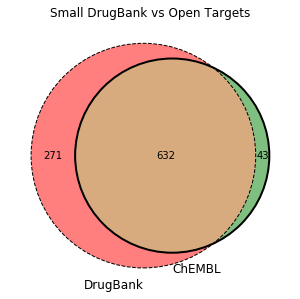

In [95]:
plt.figure(figsize=(5,5))

v = venn2(
    subsets=(only_db_sm, only_ot_sm, in_both_sm), 
    set_labels=('DrugBank', 'ChEMBL'),
    set_colors=('r', 'g'),
    alpha=0.5
)

c = venn2_circles(subsets=(only_db_sm, only_ot_sm, in_both_sm))
c[0].set_lw(1.0)
c[0].set_ls('dashed')

plt.title('Small DrugBank vs Open Targets')
# plt.show()
plt.savefig('output/figures/drugbank_open_targets_sm.png')